# 使用 Estimators 构建一个线性模型

## 概览

这份端到端演示使用 `tf.estimator` API 训练了一个逻辑回归模型。这个模型常被用作其他更复杂的算法的基线。

## 设置

In [1]:
!pip install sklearn

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib

## 加载泰坦尼克号数据集
你将使用泰坦尼克数据集，其中包含乘客的性别、年龄、船舱等级等属性，（相当病态的）目标是预测乘客的存活几率。

In [3]:
!pip install tensorflow==2.0.0-beta1
import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
  Found existing installation: tb-nightly 1.15.0a20190806
    Uninstalling tb-nightly-1.15.0a20190806:
      Successfully uninstalled tb-nightly-1.15.0a20190806
  Found existing installation: tf-estimator-nightly 1.14.0.dev2019080601
    Uninstalling tf-estimator-nightly-1.14.0.dev2019080601:
      Successfully uninstalled tf-estimator-nightly-1.14.0.dev2019080601
  Found existing installation: tensorflow 2.0.0
    Uninstalling tensorflow-2.0.0:
      Successfully uninstalled tensorflow-2.0.0


ERROR: Could not install packages due to an EnvironmentError: [WinError 5] 拒绝访问。: 'c:\\users\\wangxingda\\appdata\\local\\programs\\python\\python37\\lib\\site-packages\\tensorflow_core\\~ite\\experimental\\microfrontend\\python\\ops\\_audio_microfrontend_op.so'
Consider using the `--user` option or check the permissions.



In [4]:
# 加载数据集。
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')

## 探索数据

数据集包含以下特征

In [5]:
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [6]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


在训练集和验证集中分别有 627 和 264 个样本

In [7]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

大部分乘客是 20 多岁和 30 多岁。

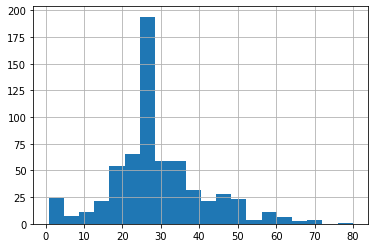

In [8]:
dftrain.age.hist(bins=20)

船上的男性乘客数量大概是女性乘客的两倍。

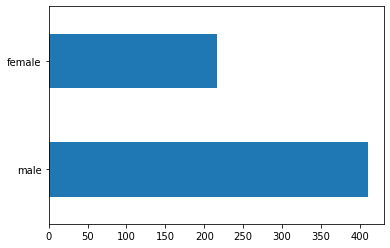

In [9]:
dftrain.sex.value_counts().plot(kind='barh')

大部分乘客在“三等”舱。

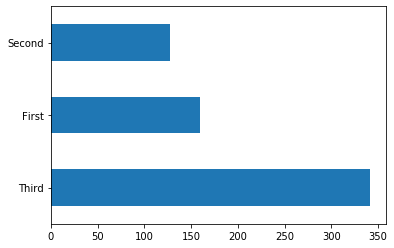

In [10]:
dftrain['class'].value_counts().plot(kind='barh')

女性的存活几率远大于男性。对模型来说这显然是一个可预测的特征。

Text(0.5, 0, '% survive')

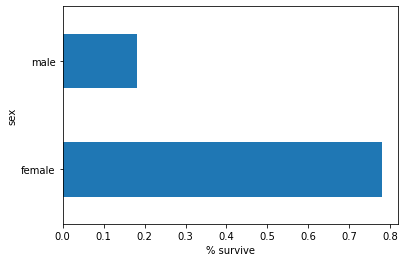

In [11]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

## 模型的特征工程
Estimators 使用一个名叫 [feature columns（特征列）](https://tensorflow.google.cn/guide/feature_columns) 的系统来描述模型应该如何解读每一个原始输入特征。一个 Estimator 期望一个数字输入向量，*特征列* 描述模型应该如何转换每个特征。

要学习一个有效的模型，关键是选择和制作一组正确的特征列。一个特征列可能是初始特征 `dict` 中的一组原始输入（一个*基本特征列*），或者是使用基于一个或多个基本列的变换而创建的任何新列（一组*派生特征列*）。

线性 estimator 使用数字型特征和类别型特征。特征列可用于所有 TensorFlow estimator，它们的目的是定义用于模型的特征列。并且，它们提供一些特征工程能力，比如 one-hot-encoding（独热编码），normalization（归一化）和 bucketization（分段）。

### 基本特征列

In [12]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']

feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))

for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

`input_function` 指定数据如何被转换为一个 `tf.data.Dataset`，该数据集以流的方式投喂输入管道。`tf.data.Dataset` 接受多个来源，如数据帧、csv格式文件等等。

In [13]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
  def input_function():
    ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
    if shuffle:
      ds = ds.shuffle(1000)
    ds = ds.batch(batch_size).repeat(num_epochs)
    return ds
  return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

你可以检查数据集：

In [14]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
  print('Some feature keys:', list(feature_batch.keys()))
  print()
  print('A batch of class:', feature_batch['class'].numpy())
  print()
  print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']

A batch of class: [b'Second' b'Third' b'Third' b'Second' b'Third' b'Third' b'Third'
 b'Second' b'Third' b'Third']

A batch of Labels: [1 0 1 1 0 0 1 1 0 0]


你也可以使用 `tf.keras.layers.DenseFeatures` 层检查特定特征列的结果：

In [15]:
age_column = feature_columns[7]
tf.keras.layers.DenseFeatures([age_column])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



array([[32.5],
       [28. ],
       [14. ],
       [45. ],
       [29. ],
       [28. ],
       [23. ],
       [32. ],
       [28. ],
       [28. ]], dtype=float32)

`DenseFeatures` 只接受密集 tensor（张量），要检查一个类别列你需要先将该列变换为一个指标列：

In [16]:
gender_column = feature_columns[0]
tf.keras.layers.DenseFeatures([tf.feature_column.indicator_column(gender_column)])(feature_batch).numpy()


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

将所有基本特征添加到模型之后，让我们来训练模型吧。使用 `tf.estimator` API 训练一个模型只需要一个命令：

In [17]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8344965, 'auc_precision_recall': 0.79169524, 'average_loss': 0.4759142, 'label/mean': 0.375, 'loss': 0.46673644, 'precision': 0.71910113, 'prediction/mean': 0.34845522, 'recall': 0.64646465, 'global_step': 200}


### 派生特征列

现在你达到了 75% 的准确率。要解释数据，分别使用每一个基本特征列可能不够。例如，性别和标签的相关性可能在不同年龄中有所差异。因此，针对 `gender="Male"` 和 `gender="Female"` 如果你只学习一个模型权重，你就不会抓住每一个“年龄-性别”组合（如：区分 `gender="Male"` - `age="30"` 和 `gender="Male"` - `age="40"`）。

要学习不同特征组合间的区别，你可以添加*交叉特征列*来建模（你也可以在交叉列之前分段年龄列）：

In [18]:
age_x_gender = tf.feature_column.crossed_column(['age', 'sex'], hash_bucket_size=100)

在模型中加入组合特征后，我们再来训练模型：

In [19]:
derived_feature_columns = [age_x_gender]
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns+derived_feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.75757575, 'accuracy_baseline': 0.625, 'auc': 0.84098566, 'auc_precision_recall': 0.7754146, 'average_loss': 0.51069945, 'label/mean': 0.375, 'loss': 0.5053589, 'precision': 0.6446281, 'prediction/mean': 0.47772083, 'recall': 0.7878788, 'global_step': 200}


现在它达到了 77.6% 的准确率，这比只用基本列训练要稍好一些。你可以尝试使用更多的特征和变换来看看你能否做得更好！

现在你可以用这个训练过的模型来预测验证集中的一名乘客。TensorFlow 模型已被优化，能同时对一个示例 batch 或者集合进行预测。之前的 `eval_input_fn` 是用这个验证集定义的。

INFO:tensorflow:Calling model_fn.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\WANGXI~1\AppData\Local\Temp\tmpnx729xpa\model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


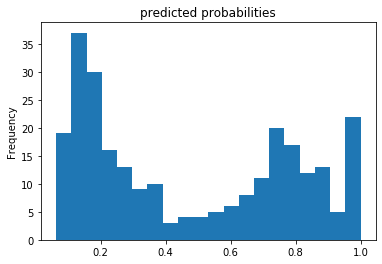

In [20]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

最后，看看结果的接收者操作特征（ROC），它会使我们更好的了解真阳性率和假阳性率之间的权衡。

(0, 1.05)

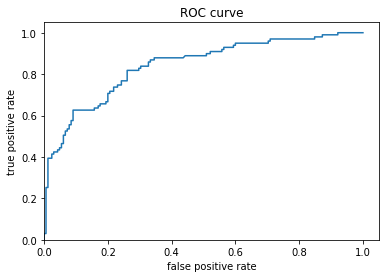

In [21]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)